<h1 style="text-align:center;">Лабораторная работа №5</h1>

<h2 style="text-align:center;">Вычисление значения определенного интеграла</h2>

<h3 style="text-align:center;">Тулупов Николай Дмитриевич</h3>
<h3 style="text-align:center;">Б01-204</h3>

### **Численное интегрирование таблично заданной функции.**
Цель: решить выбранную задачу перечисленными методами: 
1. Метод трапеций + уточнение по правилу Рунге
2. Формула Симпсона

<img src="lab_5_task_1.png" alt="drawing" width="650"/>

In [83]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [84]:
# вариант в)
x = np.array([0.0,       0.15,     0.3,      0.45,     0.6,      0.75,     0.9,      1.05,     1.2     ])
f = np.array([1.000000, 1.007568, 1.031121, 1.073456, 1.140228, 1.242129, 1.400176, 1.660300, 2.143460])

In [85]:
# Шаг сетки
h = (x[-1] - x[0]) / 8 #равномерный!

Используем метод Гаусса для решения СЛАУ из лабы 3.

In [86]:
def norm3_vect(vect):
    return pow(sum(el**2 for el in vect), 0.5)

def matr_multipl(A, B):
    
    if A.shape[1] != B.shape[0]: return 
    AB = np.zeros((A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                AB[i][j] += A[i][k] * B[k][j]
    
    return AB

def swap_rows(A, row1, row2): #функция для смены строк в матрице
    A[[row1, row2]] = A[[row2, row1]]

def swap_columns(A, col1, col2): #функция для смены столбцов в матрице
    A[:, [col1, col2]] = A[:, [col2, col1]]

def find_max_el(A, iter): #функция для поиска главного элемента матрицы A[iter,iter]
    size = len(A) - iter
    main_element = A[iter,iter]
    i_main, j_main = iter, iter

    for i in range(iter, size): 
        for j in range(iter, size):
            if abs(A[iter:, iter:][i][j]) > abs(main_element):
                i_main, j_main = i, j
                main_element = A[iter:, iter:][i][j]
    return main_element, i_main, j_main

def gauss(A, f):
    size = len(A)
    if A.shape[0] != A.shape[1]:
        print("Матрица не квадратная, решение невозможно!")
        return 
    x = np.arange(size) #массив с порядком корней (порядок будет меняться при перестановке столбцов)

    #прямой ход алгоритма - приводим матрицу A к верхнетреугольному виду
    for iter in range(len(A)):
        ''' Добавим в алгоритм проверку - если на какой-то итерации алгоритма возникла нулевая строка - ответ будет выражаться 
        через одну из переменных (её берем за константу, все остальные переменные будут выражены через нее)'''
        if (len(A) != sum(int(np.any(el)) for el in A)):
            '''Количество переменных превышает количество уравнений, решение не однозначн'''
            print("ERROR! Матрица не квадратная, решение невозможно!")
            return 
        
        main_el, i_main, j_main = find_max_el(A, iter) #максимальный элемент текущей матрицы и его местонахождение
        
        if (i_main != iter): #если элемент еще не в нулевой строке
            swap_rows(A, iter, i_main) #меняем в текущей матрице нулевую строку и строку, содержащую главный элемент            
            swap_rows(f, iter, i_main) #то же самое - в столбце решений       
            
        if (j_main != iter): #если элемент еще не в нулевом столбце
            swap_columns(A, iter, j_main) #меняем в текущей матрице нулевой столбец и столбец, содержащий главный элемент
            #swap_columns(x, iter, j_main) #то же самое - в строке порядка переменных
            x[iter], x[j_main] = x[j_main], x[iter]
        
        if main_el != 0:
            A[iter:, iter:][0] /= main_el #делим нулевую строку текущей матрицы на главный элемент
            f[iter] /= main_el #делим нулевую строку текущего столбца решений на главный элемент
        else:
            print("ERROR! main_el = 0")
            return
    
        for i in range(size - iter - 1):   
            f[i+iter+1] -= (f[iter] * A[iter:, iter:][i+1][0])
            #вычитаем из каждого элемента нулевой в текущем столбце решений, умноженный на нулевой элемент нужной строки - получаем в начале каждой строки единицу
            A[iter:, iter:][i+1] -=  (A[iter:, iter:][0] * A[iter:, iter:][i+1][0])
            #вычитаем из каждой строки нулевую, умноженную на нулевой элемент нужной строки - получаем в начале каждой строки единицу
        
    f[-1] /= A[-1][-1]
    A[size-1][size-1] = 1


    
    #обратный ход алгоритма
    U  = np.zeros((size, 1)) #столбец решений
    for i in range(size-1, -1, -1):
        U[i] = f[i]
        for j in range(i + 1, size):
            U[i] -= U[j] * A[i][j]

    #перестановка переменных в изначальном порядке
    ans = np.zeros((size, 1))
    for i in range(size):
        ans[int(x[i])] = U[i]
    
    return ans

Используем сплайн-интерполяцию из лабы 4.

In [87]:
def cubic_spline(x, y):
    
    n = len(x) - 1  # количество интервалов
    h = np.diff(x)  # длины интервалов

    # Вычисляем вектор правой части системы уравнений (f)
    f = np.zeros(n + 1)
    for i in range(1, n):
        f[i] = (3 / h[i] * (y[i + 1] - y[i]) - 3 / h[i - 1] * (y[i] - y[i - 1]))

    # Формируем матрицу A для решения системы уравнений
    A = np.zeros((n + 1, n + 1))
    b = np.zeros(n + 1)

    for i in range(1, n):
        A[i, i - 1] = h[i - 1]  # нижняя диагональ
        A[i, i] = 2 * (h[i - 1] + h[i])  # главная диагональ
        A[i, i + 1] = h[i]  # верхняя диагональ
        b[i] = f[i]

    # Граничные условия
    A[0, 0] = 1
    A[n, n] = 1
  
    # Решаем систему линейных уравнений для коэффициентов c
    c = gauss(A, b)

    # Вычисляем коэффициенты a, b, d
    a = y[:-1]
    b = np.zeros(n)
    d = np.zeros(n)

    for i in range(n):
        b[i] = (y[i + 1] - y[i]) / h[i] - h[i] * (2 * c[i][0] + c[i + 1][0]) / 3
        d[i] = (c[i + 1][0] - c[i][0]) / (3 * h[i])

    return a, b, c[:-1], d

def value_spline(x, a, b, c, d, xi):
    n = len(a)
    for i in range(n):
        if x[i] <= xi <= x[i + 1]:
            dx = xi - x[i]
            return a[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3
    raise ValueError("xi вне диапазона x")


##### **1) Классический метод трапеций с уточнением по правилу Рунге.**

In [88]:
# Метод трапеций
def trapezoid(x, f):
    n = len(x) - 1
    integral = 0.5 * h * (f[0] + 2 * np.sum(f[1:n]) + f[n])
    return integral

In [89]:
# правило Рунге
def runge(I_h, I_2h, p = 2):
    return I_h + (I_h - I_2h) / (2**p - 1)

In [90]:
# метод трапеций с уточнением по правилу Рунге
def trapezoid_runge(x, y):
    I_h = trapezoid(x, y)
    I_2h = 0

    a, b, c, d = cubic_spline(x, y)

    for i in range(len(x) - 1):
        x_val = (x[i] + x[i+1]) / 2
        y_val = value_spline(x, a, b, c, d, x_val)

        I_2h += 0.5 * (y_val + y[i]) * (x_val - x[i])
        I_2h += 0.5 * (y_val + y[i+1]) * (x[i+1] - x_val)
    
    return (runge(I_h, I_2h, p = 2))

In [91]:
I_trap = float(trapezoid(x, f))
I_trap_runge = float(trapezoid_runge(x, f).item())
print(I_trap, I_trap_runge)


1.5190062 1.5201664500326684


##### **2) Метод Симпсона.**

Для приближённого вычисления определённого интеграла на равномерной сетке используется **метод Симпсона**:

$$
\int_a^b f(x) \, dx \approx \frac{h}{3} \left[ f(x_0) + 4f(x_1) + 2f(x_2) + 4f(x_3) + \dots + 2f(x_{n-2}) + 4f(x_{n-1}) + f(x_n) \right],
$$

где:

- $ x_0, x_1, \dots, x_n $ — узлы равномерного разбиения на отрезке $ [a, b] $
- $ h = \frac{b - a}{n} $ — шаг разбиения,
- $ n $ — чётное количество подотрезков,
- $ f(x_0), f(x_1), \dots, f(x_n)$ — значения функции в узлах.

**Коэффициенты 4 и 2** чередуются:
- $ 4 \cdot f(x_i) $ для нечётных узлов $ x_1, x_3, \dots $,
- $ 2 \cdot f(x_i) $ для чётных узлов $ x_2, x_4, \dots $,
- $ f(x_0) $ и $ f(x_n) $ учитываются с коэффициентом 1 (границы отрезка).

Формула применяется для чётного $ n $, так как каждых два подотрезка аппроксимируются одной параболой.


In [92]:
#метод Симпсона
def simpson(x, y):
    
    num_intervals = len(x) - 1  # Количество подотрезков (должно быть чётным для метода Симпсона)
    
    if num_intervals % 2 != 0:
        raise ValueError("Метод Симпсона требует чётное количество подотрезков.")

    step_size = (x[-1] - x[0]) / num_intervals  # Шаг разбиения
    integral_sum = y[0] + y[-1]  # Начинаем с первого и последнего значений функции

    # Суммируем 4 * f(x_i) для нечётных индексов (средние точки на каждом подотрезке)
    for i in range(1, num_intervals, 2):
        integral_sum += 4 * y[i]
    
    # Суммируем 2 * f(x_i) для чётных индексов (внутренние точки на границах подотрезков)
    for i in range(2, num_intervals, 2):
        integral_sum += 2 * y[i]
    
    # Умножаем сумму на шаг / 3 для получения окончательного значения интеграла
    integral = (step_size / 3) * integral_sum
    
    return integral

In [93]:
I_simpson = float(simpson(x, f))
print(I_simpson)

1.5110161


### **Численное интегрирование быстро осциллирующей функции.**

Вариант б) :  $\int_1^2 cos(100x)ln(x)dx$

<img src="lab_5_task_2.png" alt="drawing" width="650"/>

Посмотрим, как выглядит такая функция:

<img src="rapidly_oscillating.png" alt="drawing" width="1000"/>

Хотя зачем нам desmos, мы ведь написали интерполяцию!

Нарисуем эту функцию - возьмем за отсчеты 100 точек, построим кубический сплайн и посчитаем его знечение в 1000 точках.

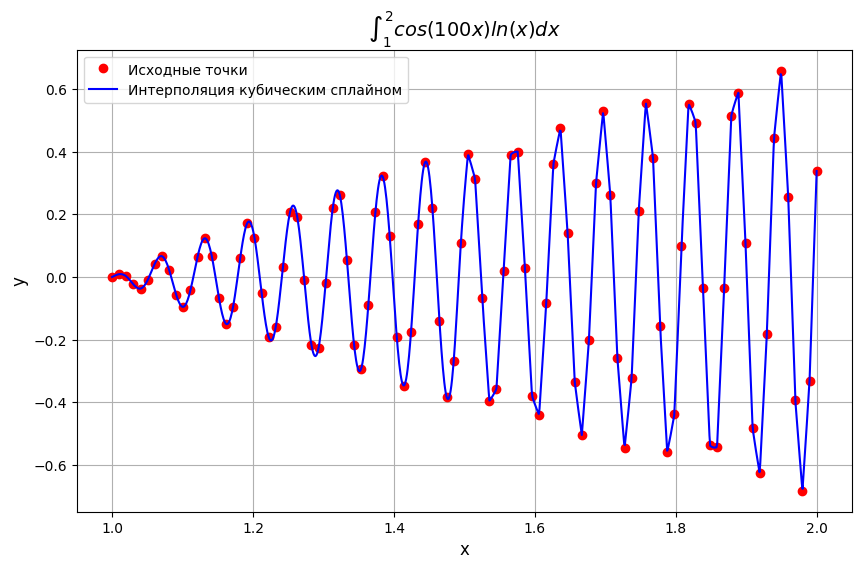

In [94]:
x = np.linspace(1, 2, 100)
y = np.cos(100*x)*np.log(x)

plt.figure(figsize=(10, 6))

#исходные данные - заданные для интерполяции точки
plt.plot(x, y, '.', color='red')

# Строим сплайн
a, b, c, d = cubic_spline(x, y)



# Оцениваем значение сплайна
x_dense = np.linspace(1, 2, 1000)
y_dense = [value_spline(x, a, b, c, d, xi) for xi in x_dense]


plt.plot(x, y, 'o', label="Исходные точки", color = "red")
plt.plot(x_dense, y_dense, label="Интерполяция кубическим сплайном", color = "blue")


plt.title('$\int_1^2 cos(100x)ln(x)dx$', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

In [95]:





# Создаём сетку
a, b = 1, 2  # Пределы интегрирования
n = 1000  # Количество узлов (чем больше, тем точнее для осциллирующих функций)


x = np.linspace(a, b, n + 1)
y = f(x)


# Вычисляем интеграл методом трапеций
I_trap_h = trapezoid_runge(x, y)

# Уменьшаем шаг в 2 раза и пересчитываем
x_fine = np.linspace(a, b, 2 * n + 1)
y_fine = f(x_fine)
I_trap_2h = trapezoid_runge(x_fine, y_fine)

# Уточняем результат по правилу Рунге
I_runge = runge(I_trap_2h, I_trap_h)

# Вычисляем интеграл методом Симпсона
I_simpson = simpsons_integral(x, y)

# Вывод результатов
print(f"Интеграл методом трапеций (шаг h): {I_trap_h:.6f}")
print(f"Интеграл методом трапеций (шаг 2h): {I_trap_2h:.6f}")
print(f"Уточнённый результат по правилу Рунге: {I_runge:.6f}")
print(f"Интеграл методом Симпсона: {I_simpson:.6f}")




KeyboardInterrupt: 

In [82]:
# Создаём сетку
a, b = 1, 2  # Пределы интегрирования
n = 1000  # Количество узлов (чем больше, тем точнее для осциллирующих функций)


x = np.linspace(a, b, n + 1)
y = f(x)


I_trap = float(trapezoid(x, y))
I_trap_runge = float(trapezoid_runge(x, y).item())
print(I_trap, I_trap_runge)


I_simpson = float(simpson(x, y))
print(I_simpson)

KeyboardInterrupt: 

Убедимся в правильности ответа с помощью Wolfram

<img src="wolframalpha.png" alt="drawing" width="650"/>